In [0]:
# import externals
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

import numpy as np
import pandas as pd
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import sklearn 
import scipy.special as spsp
from scipy.optimize import minimize
import scipy.stats as spst
import folium
from folium import plugins
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [0]:
# Import data
link="https://drive.google.com/open?id=1yfXwOOaOd_EpZaKAF6atAtjjj7YeoTd1"
_,id=link.split("=")
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('AB_NYC_2019.csv')  

AirBnb = pd.read_csv('AB_NYC_2019.csv')
AirBnb.head(3)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2595,https://www.airbnb.com/rooms/2595,20191204162729,2019-12-07,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...","- Spacious (500+ft²), immaculate and nicely fu...","Beautiful, spacious skylit studio in the heart...",none,Centrally located in the heart of Manhattan ju...,NaN,Apartment is located on 37th Street between 5t...,"Guests have full access to the kitchen, bathro...",I am a Sound Therapy Practitioner and Kundalin...,"Make yourself at home, respect the space and t...",NaN,NaN,https://a0.muscache.com/im/pictures/f0813a11-4...,NaN,2845,https://www.airbnb.com/users/show/2845,Jennifer,2008-09-09,"New York, New York, United States",A New Yorker since 2000! My passion is creatin...,within a day,85%,NaN,f,https://a0.muscache.com/im/users/2845/profile_...,https://a0.muscache.com/im/users/2845/profile_...,Midtown,6.0,6.0,"['email', 'phone', 'reviews', 'offline_governm...",t,t,"New York, NY, United States",Midtown,Midtown,...,$0.00,10,1125,10,10,1125,1125,10.0,1125.0,2 weeks ago,t,1,1,1,1,2019-12-07,48,7,2009-11-21,2019-11-04,94.0,9.0,9.0,10.0,10.0,10.0,9.0,f,NaN,NaN,f,f,strict_14_with_grace_period,t,t,1,1,0,0,0.39
1,3831,https://www.airbnb.com/rooms/3831,20191204162729,2019-12-07,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Greetings! We own a double-duplex brownst...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,none,Just the right mix of urban center and local n...,NaN,B52 bus for a 10-minute ride to downtown Brook...,You will have exclusive use of and access to: ...,"We'll be around, but since you have the top fl...",Smoking - outside please; pets allowed but ple...,NaN,NaN,https://a0.muscache.com/im/pictures/e49999c2-9...,NaN,4869,https://www.airbnb.com/users/show/4869,LisaRoxanne,2008-12-07,"New York, New York, United States",Laid-back bi-coastal actor/professor/attorney.,within an hour,100%,NaN,f,https://a0.muscache.com/im/users/4869/profile_...,https://a0.muscache.com/im/users/4869/profile_...,Clinton Hill,1.0,1.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Brooklyn, NY, United States",Brooklyn,Clinton Hill,...,$0.00,1,730,1,1,730,730,1.0,730.0,2 weeks ago,t,1,1,1,1,2019-12-07,295,75,2014-09-30,2019-11-22,90.0,9.0,9.0,10.0,9.0,10.0,9.0,f,NaN,NaN,f,f,moderate,f,f,1,1,0,0,4.67
2,5099,https://www.airbnb.com/rooms/5099,20191204162729,2019-12-06,Large Cozy 1 BR Apartment In Midtown East,My large 1 bedroom apartment has a true New Yo...,I have a large 1 bedroom apartment centrally l...,My large 1 bedroom apartment has a true New Yo...,none,My nei

## **Data Manipulation**

In [0]:
# drop columns with more than 25% missing values or column name contain 'url' or 'host'
for col in AirBnb.columns:
  if (np.sum(AirBnb[col].isnull()) > (AirBnb.shape[0]/4)) or (col.find('url') != -1):
    AirBnb = AirBnb.drop(columns=col)
  # drop constant variable
  elif len(AirBnb[col].value_counts()) == 1:
    AirBnb = AirBnb.drop(columns=col)

AirBnb = AirBnb.drop(columns=['summary','description',\
                              'host_id','host_location',\
                              'host_neighbourhood','host_listings_count','host_total_listings_count',\
                              'host_verifications','host_has_profile_pic',\
                              'street',\
                              'city','state','zipcode','market','smart_location'])
AirBnb = AirBnb.drop(columns=['amenities','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights',\
                              'maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm',\
                              'availability_30','availability_60','availability_90',\
                              'require_guest_profile_picture','require_guest_phone_verification',\
                              'calculated_host_listings_count','calculated_host_listings_count_entire_homes',\
                              'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms'])
#AirBnb.head(3)

# print(AirBnb.shape)
# print(np.sum(AirBnb.isnull()))

AirBnb = AirBnb.dropna(axis=0)
# change the type of price, cleaning_fee, extra_people
for i in ['price', 'cleaning_fee', 'extra_people']:
  AirBnb[i] = AirBnb[i].replace('[\$,]', '', regex=True).astype(float)
print(AirBnb.shape)
# print(AirBnb.dtypes)
AirBnb.head(5)

(32956, 43)


,id,last_scraped,name,host_name,host_since,host_is_superhost,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,reviews_per_month
0,2595,2019-12-07,Skylit Midtown Castle,Jennifer,2008-09-09,f,t,Midtown,Midtown,Manhattan,40.75362,-73.98377,f,Apartment,Entire home/apt,1,1.0,0.0,1.0,Real Bed,225.0,95.0,1,0.0,10,1125,2 weeks ago,1,2019-12-07,48,7,2009-11-21,2019-11-04,94.0,9.0,9.0,10.0,10.0,10.0,9.0,f,strict_14_with_grace_period,0.39
2,5099,2019-12-06,Large Cozy 1 BR Apartment In Midtown East,Chris,2009-02-02,f,f,Manhattan,Murray Hill,Manhattan,40.74767,-73.97500,f,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,200.0,125.0,2,100.0,3,21,2 weeks ago,19,2019-12-06,78,8,2009-04-20,2019-10-13,90.0,10.0,9.0,10.0,10.0,10.0,9.0,f,moderate,0.60
4,5178,2019-12-05,Large Furnished Room Near B'way,Shunichi,2009-03-03,f,f,Manhattan,Hell's Kitchen,Manhattan,40.76489,-73.98493,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,79.0,15.0,1,12.0,2,14,2 months ago,242,2019-12-05,454,47,2009-05-06,2019-11-21,84.0,9.0,7.0,9.0,9.0,10.0,8.0,f,strict_14_with_grace_period,3.52
6,5238,2019-12-05,Cute & Cozy Lower East Side 1 bdrm,Ben,2009-02-07,t,t,Lower East Side,Chinatown,Manhattan,40.71344,-73.99037,t,Apartment,Entire home/apt,3,1.0,1.0,2.0,Real Bed,150.0,40.0,2,10.0,1,1125,yesterday,1,2019-12-05,161,9,2009-09-01,2019-07-29,94.0,10.0,9.0,10.0,10.0,9.0,9.0,f,strict_14_with_grace_period,1.29
7,5441,2019-12-06,Central Manhattan/near Broadway,Kate,2009-02-16,t,t,Manhattan,Hell's Kitchen,Manhattan,40.76076,-73.98867,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,85.0,0.0,1,0.0,3,7,a week ago,10,2019-12-06,204,36,2009-03-12,2019-11-20,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,moderate,1.56


# **Data Split**

In [0]:
# split data into training(80%), testing(10%) and validaition(10%) sets
training = AirBnb[0:int(0.80*AirBnb.shape[0])]
validation = AirBnb[int(0.80*AirBnb.shape[0]):int(0.90*AirBnb.shape[0])]
testing = AirBnb[int(0.90*AirBnb.shape[0]):]

## **Exploratory Data Analysis**

In [0]:
plot_cols = ['id', 'host_is_superhost',
       'host_identity_verified', 'neighbourhood',
       'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'price', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'calendar_updated', 'availability_365', 
       'number_of_reviews', 'number_of_reviews_ltm', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'cancellation_policy',
       'reviews_per_month']

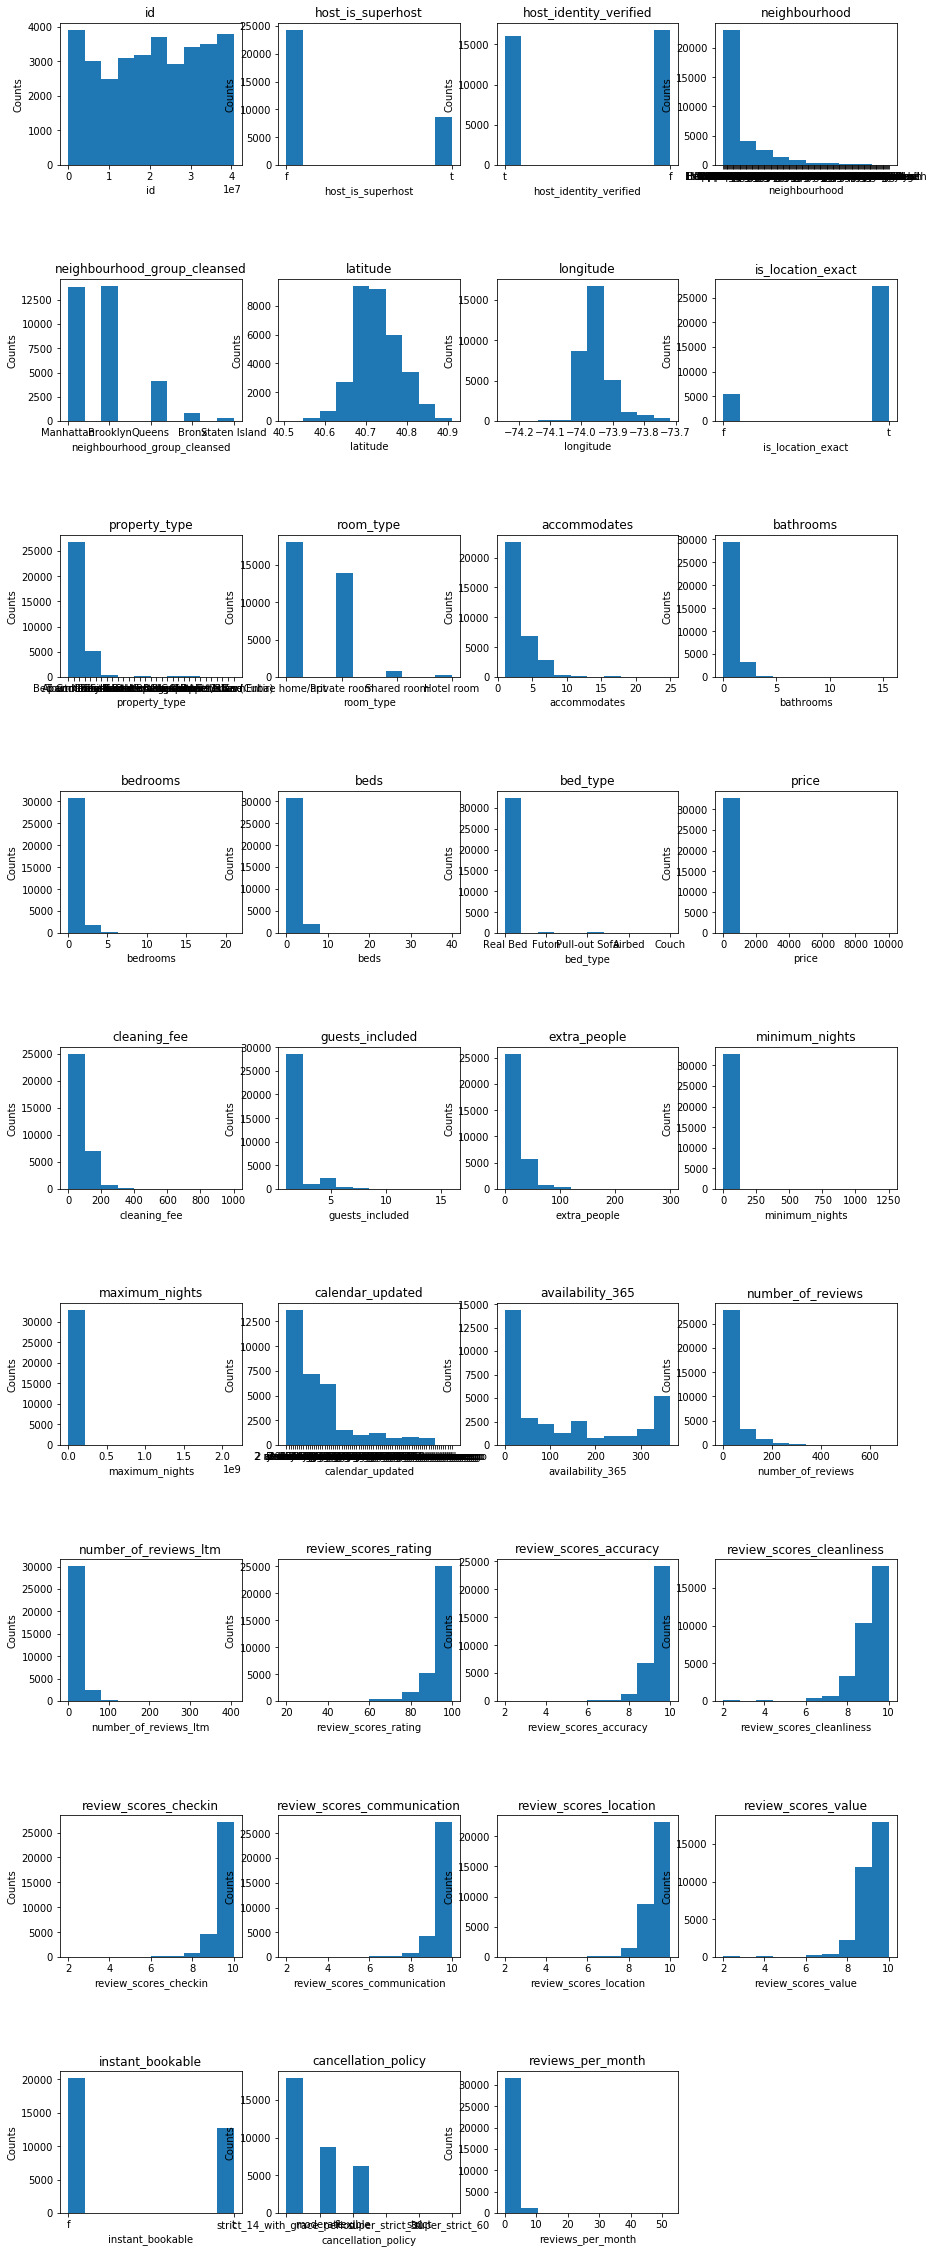

In [0]:
plt.figure(figsize=(15,45))
i = 1
for column in plot_cols:
  plt.subplot(10,4,i)
  plt.hist(AirBnb[column])
  plt.xlabel(column)
  plt.ylabel('Counts')
  plt.title(column)
  i += 1
plt.subplots_adjust(hspace=0.8) 

(array([3058., 4358., 5105., 4423., 4586., 4450., 3729., 2419.,  758.,
          70.]),
 array([0.        , 0.65147127, 1.30294254, 1.95441381, 2.60588508,
        3.25735635, 3.90882761, 4.56029888, 5.21177015, 5.86324142,
        6.51471269]),
 <a list of 10 Patch objects>)

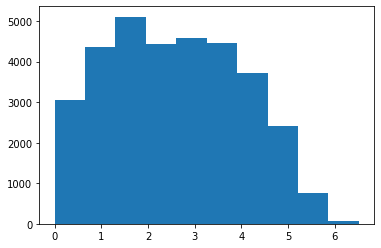

In [0]:
plt.hist(np.log(AirBnb['number_of_reviews']))

(array([22888.,  5074.,  1246.,   335.,   305.,   122.,   133.,    88.,
           73.,   266.]),
 array([ 1. ,  3.8,  6.6,  9.4, 12.2, 15. , 17.8, 20.6, 23.4, 26.2, 29. ]),
 <a list of 10 Patch objects>)

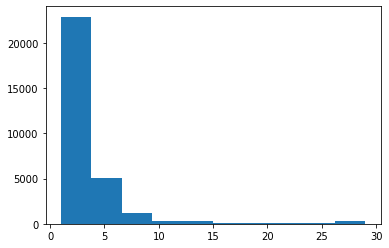

In [0]:
plt.hist(AirBnb['minimum_nights'][AirBnb['minimum_nights']<30])

(array([8062.,    0., 8966., 5860., 4561., 1619.,  405.,  375.,  255.,
         427.]),
 array([0.        , 0.33672958, 0.67345917, 1.01018875, 1.34691833,
        1.68364791, 2.0203775 , 2.35710708, 2.69383666, 3.03056625,
        3.36729583]),
 <a list of 10 Patch objects>)

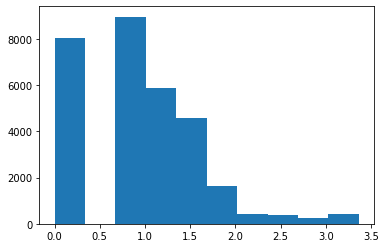

In [0]:
plt.hist(np.log(AirBnb['minimum_nights'][AirBnb['minimum_nights']<30]))

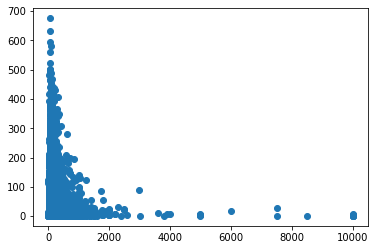

In [0]:
price = AirBnb['price']
review_num = AirBnb['number_of_reviews']
plt.scatter(price,review_num)

## Houses recommendation engine

In [0]:
# Get rid of all observations with missing values in the concerned features
airbnb_NN = AirBnb[~AirBnb['reviews_per_month'].isna()]
airbnb_NN = airbnb_NN[~airbnb_NN['host_is_superhost'].isna()]
airbnb_NN = airbnb_NN[~airbnb_NN['bathrooms'].isna()]
airbnb_NN = airbnb_NN[~airbnb_NN['bedrooms'].isna()]
airbnb_NN= airbnb_NN[~airbnb_NN['beds'].isna()]

# Fill the missing value in 'review_scores_rating' with -1
# meaning the house has not received any rating yet
airbnb_NN['review_scores_rating'] = airbnb_NN['review_scores_rating'].fillna(-1)

In [0]:
# data preprocessing for NearestNeighbors

# Get rid of the houses of price 0
airbnb_NN = airbnb_NN[airbnb_NN["price"]>0]
Private_room = pd.get_dummies(airbnb_NN["room_type"])["Private room"]
Entire = pd.get_dummies(airbnb_NN["room_type"])["Entire home/apt"]
Shared_room = pd.get_dummies(airbnb_NN["room_type"])["Shared room"]
Hotel_room = pd.get_dummies(airbnb_NN["room_type"])["Hotel room"]
airbnb_NN = airbnb_NN.assign(Private_room = Private_room, Entire_home_apt = Entire,\
                       Shared_room = Shared_room, Hotel_room = Hotel_room)
# Convert the categorical room_type into dummies
Exact_location = pd.get_dummies(airbnb_NN["is_location_exact"])["t"]
Not_Exact_location = pd.get_dummies(airbnb_NN["is_location_exact"])["f"]
airbnb_NN = airbnb_NN.assign(Exact_location=Exact_location, Not_Exact_location=Not_Exact_location)
Is_superhost = pd.get_dummies(airbnb_NN["host_is_superhost"])["t"]
Is_not_superhost = pd.get_dummies(airbnb_NN["host_is_superhost"])["f"]
airbnb_NN = airbnb_NN.assign(Is_superhost=Is_superhost, Is_not_superhost=Is_not_superhost)
verified = pd.get_dummies(airbnb_NN["host_identity_verified"])["t"]
not_verified = pd.get_dummies(airbnb_NN["host_identity_verified"])["f"]
airbnb_NN = airbnb_NN.assign(verified=verified, not_verified=not_verified)

Airbed = pd.get_dummies(airbnb_NN["bed_type"])["Airbed"]
Couch = pd.get_dummies(airbnb_NN["bed_type"])["Couch"]
Sofa = pd.get_dummies(airbnb_NN["bed_type"])["Pull-out Sofa"]
Real_bed = pd.get_dummies(airbnb_NN["bed_type"])["Real Bed"]
airbnb_NN = airbnb_NN.assign(Airbed = Airbed, Couch = Couch,\
                       Sofa = Sofa, Real_bed = Real_bed)

# Restructure the data based on the features needed
airbnb_NN = airbnb_NN[[ "id","name", "host_name","host_is_superhost","host_identity_verified","neighbourhood",\
                       "neighbourhood_cleansed", "is_location_exact",\
                       "room_type", "bed_type", "Exact_location", "Not_Exact_location",\
                       "Is_superhost", "Is_not_superhost", "verified", "not_verified", "latitude","longitude",\
                       "Private_room", "Entire_home_apt", "Shared_room", "Hotel_room", "price", "accommodates" ,\
                       "bathrooms", "bedrooms", "beds", "Airbed", "Couch", "Sofa", "Real_bed",\
                       "last_review", "reviews_per_month", "review_scores_rating"]]

# Convert the datatype of "last_review" column into datetime64
airbnb_NN = airbnb_NN.astype({"last_review":"datetime64"})
airbnb_NN.head(500)

,id,name,host_name,host_is_superhost,host_identity_verified,neighbourhood,neighbourhood_cleansed,is_location_exact,room_type,bed_type,Exact_location,Not_Exact_location,Is_superhost,Is_not_superhost,verified,not_verified,latitude,longitude,Private_room,Entire_home_apt,Shared_room,Hotel_room,price,accommodates,bathrooms,bedrooms,beds,Airbed,Couch,Sofa,Real_bed,last_review,reviews_per_month,review_scores_rating
0,2595,Skylit Midtown Castle,Jennifer,f,t,Midtown,Midtown,f,Entire home/apt,Real Bed,0,1,0,1,1,0,40.75362,-73.98377,0,1,0,0,225.0,1,1.0,0.0,1.0,0,0,0,1,2019-11-04,0.39,94.0
2,5099,Large Cozy 1 BR Apartment In Midtown East,Chris,f,f,Manhattan,Murray Hill,f,Entire home/apt,Real Bed,0,1,0,1,0,1,40.74767,-73.97500,0,1,0,0,200.0,2,1.0,1.0,1.0,0,0,0,1,2019-10-13,0.60,90.0
4,5178,Large Furnished Room Near B'way,Shunichi,f,f,Manhattan,Hell's Kitchen,t,Private room,Real Bed,1,0,0,1,0,1,40.76489,-73.98493,1,0,0,0,79.0,2,1.0,1.0,1.0,0,0,0,1,2019-11-21,3.52,84.0
6,5238,Cute & Cozy Lower East Side 1 bdrm,Ben,t,t,Lower East Side,Chinatown,t,Entire home/apt,Real Bed,1,0,1,0,1,0,40.71344,-73.99037,0,1,0,0,150.0,3,1.0,1.0,2.0,0,0,0,1,2019-07-29,1.29,94.0
7,5441,Central Manhattan/near Broadway,Kate,t,t,Manhattan,Hell's Kitchen,t,Private room,Real Bed,1,0,1,0,1,0,40.76076,-73.98867,1,0,0,0,85.0,2,1.0,1.0,1.0,0,0,0,1,2019-11-20,1.56,97.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,252076,+Highly Satisfactory LES dwelling++,Tunji,t,t,Lower East Side,Chinatown,t,Private room,Real Bed,1,0,1,0,1,0,40.71460,-73.99100,1,0,0,0,115.0,2,1.0,1.0,1.0,0,0,0,1,2019-11-21,1.63,96.0
627,252607,Whole apartment / 2 bedroom in NYC,Chris,f,f,East Harlem,East Harlem,t,Entire home/apt,Real Bed,1,0,0,1,0,1,40.79493,-73.94462,0,1,0,0,200.0,4,1.0,2.0,2.0,0,0,0,1,2018-08-09,0.50,99.0
628,252865,BEST NEIGHBORHOOD!...NY Magazine,Grace,f,t,Prospect Heights,Prospect Heights,t,Private room,Real Bed,1,0,0,1,1,0,40.67918,-73.97212,1,0,0,0,87.0,1,1.0,1.0,1.0,0,0,0,1,2019-11-02,0.08,96.0
629,253332,"Spacious, modern loft in awesome neighborhood",Cynthia,f,t,Greenwood Heights,Sunset Park,t,Entire home/apt,Real Bed,1,0,0,1,1,0,40.66230,-73.99049,0,1,0,0,96.0,6,2.0,3.0,5.0,0,0,0,1,2018-09-01,0.13,98.0


In [0]:
# Median of reviews_per_month, a threshold for popular/unpopular
median_rpm = np.percentile(airbnb_NN["reviews_per_month"].values,0.5)
# The houses whose numbers of reviews per month is lower than the median 0.02
# or those whose last review was before 2019-01-01 are considered as unpopular.
# We hereby filter out the unpopular houses and gather them into the dataframe "unpopular"
# And the popular houses are gathered into the dataframe "popular"

filt = np.logical_or((airbnb_NN["last_review"]<"2019-01-01").values, airbnb_NN["reviews_per_month"].values < median_rpm)
unpopular = airbnb_NN[filt]
popular = airbnb_NN[np.logical_not(filt)]
# Only houses with rating higher than 80 or those who have never been rated before are qualified
# to be recommended to the users
popular = popular[(popular["review_scores_rating"]>80) | (popular["review_scores_rating"]==-1)]
unpopular = unpopular[(unpopular["review_scores_rating"]>80) | (unpopular["review_scores_rating"]==-1)]

In [0]:
# Standardization
from sklearn.preprocessing import StandardScaler

# For recommendations from the unpopular houses
scaler = StandardScaler()
scaler.fit(unpopular.iloc[:,10:31])
unpopular_sd = scaler.transform(unpopular.iloc[:,10:31])
airbnb_NN_sd = scaler.transform(airbnb_NN.iloc[:,10:31])

# For recommendations from the popular houses
scaler1 = StandardScaler()
scaler1.fit(popular.iloc[:,10:31])
popular_sd = scaler1.transform(popular.iloc[:,10:31])
airbnb_NN_sd1 = scaler1.transform(airbnb_NN.iloc[:,10:31])


In [0]:
from sklearn.neighbors import NearestNeighbors
row_labels = airbnb_NN.index.values
def recommendation(viewed_houses, num_pop, num_unpop):

  '''
  Input: 
  viewed_houses: List of ids of the houses viewed by a user
  num_pop: Number of popular houses recommended to the user
  num_unpop: Number of unpopular houses recommended to the user

  Output:
  recommendations: pandas dataframe of the popular and unpopular houses recommended 
  to the user
  '''

  # We need to first convert row label into positional index
  # because we can only use positional index on the standardized data.
  # The standardized data exist in form of ndarray.
  indices = []
  for id in viewed_houses:
    label = airbnb_NN[airbnb_NN["id"]==id].index
    # The invalid ids will be ignored.
    # They won't cause any error.
    if len(label) != 0:
      index = np.where(row_labels==label[0])[0]
      indices.append(index[0])

  N = unpopular.shape[0]

  # Recommend from unpopular using unsupervised KNN
  model_NN_upop = NearestNeighbors(n_neighbors=N)
  model_NN_upop.fit(unpopular_sd)
  distances_up, indices_up = model_NN_upop.radius_neighbors(airbnb_NN_sd[indices,:], \
                                               radius = np.inf)
  distance_up = np.sum(distances_up)
  indices_reordered_up=np.argsort(distance_up)
  # Take the num_unpop closest points and display the text information users would care about
  output_up = unpopular.iloc[indices_reordered_up[0:num_unpop],[0,1,2,3,4,7,5,6,8,22,23,24,25,26,9,-1]]

  # Recommend from popular using unsupervised KNN
  model_NN_pop = NearestNeighbors(n_neighbors=N)
  model_NN_pop.fit(popular_sd)
  distances_p, indices_p = model_NN_pop.radius_neighbors(airbnb_NN_sd1[indices,:], \
                                               radius = np.inf)
  distance_p = np.sum(distances_p)
  indices_reordered_p=np.argsort(distance_p)
  # Take the num_pop closest points and display the text information users would care about
  output_p = popular.iloc[indices_reordered_p[0:num_pop],[0,1,2,3,4,7,5,6,8,22,23,24,25,26,9,-1]]
  
  recommendations = pd.concat([output_p, output_up])
  return recommendations


recommendation([5441, 5178, 252607, 5023], 6, 8)

,id,name,host_name,host_is_superhost,host_identity_verified,is_location_exact,neighbourhood,neighbourhood_cleansed,room_type,price,accommodates,bathrooms,bedrooms,beds,bed_type,review_scores_rating
20983,18255225,Lovely Studio,Victoria,f,t,f,Midwood,Midwood,Shared room,85.0,2,1.0,1.0,1.0,Real Bed,98.0
20935,18207319,Brownstone w/ Luxurious private room & bay win...,Tee,f,t,f,Longwood,Longwood,Private room,75.0,2,1.0,1.0,1.0,Real Bed,97.0
23051,19911778,Brooklyn Backyard Oasis,Magnus,f,f,t,Brooklyn,Bay Ridge,Entire home/apt,125.0,4,1.0,3.0,3.0,Real Bed,95.0
22284,19348588,Bright Renewed Apartment 1 minute from 1 train,Baden,t,f,t,Manhattan,Washington Heights,Private room,60.0,2,1.0,1.0,1.0,Real Bed,97.0
25034,21365786,Sunny 2BR in Heart of Williamsburg Near Subway,Rob,f,f,t,Manhattan,East Village,Private room,215.0,1,1.0,1.0,1.0,Real Bed,88.0
27113,22455153,2 Bedroom - Midtown off 5th Ave,Deo,f,t,t,Manhattan,Midtown,Entire home/apt,220.0,5,1.0,2.0,2.0,Real Bed,90.0
29239,24687253,Ctrl Park/Ts Square Private Room for 1 or 2 pe...,Clark,f,f,t,Midtown,Hell's Kitchen,Private room,99.0,2,1.0,1.0,1.0,Real Bed,99.0
1441,698094,5th Ave Apartment in Midtown!,Kristen,f,f,t,Midtown,Midtown,Private room,120.0,2,1.0,1.0,1.0,Real Bed,99.0
14030,11866156,Apt in Heart of Hell's Kichen,Marissa,f,f,t,Midtown,Hell's Kitchen,Private room,79.0,2,1.0,1.0,1.0,Real Bed,100.0
33951,29543762,"Room w/private bathroom, Central Park & Times Sq",Mariano,f,f,t,Midtown,Midtown,Private room,160.0,2,1.0,1.0,1.0,Real Bed,100.0


In [0]:
reviews_per_month=airbnb_NN['reviews_per_month'].values
np.median(reviews_per_month)

0.91

# Random Forest regressor

In [0]:
airbnbgo=AirBnb.copy()
airbnbgo = airbnbgo[airbnbgo["price"]>0]
airbnbgo=airbnbgo.assign(ratings=airbnbgo['review_scores_rating'].values)
airbnbgo=airbnbgo.assign(logprice=np.log(airbnbgo['price'].values))
airbnbgo=airbnbgo.assign(Manhattan=pd.get_dummies(airbnbgo['neighbourhood_group_cleansed'])['Manhattan'])
airbnbgo=airbnbgo.assign(Brooklyn=pd.get_dummies(airbnbgo['neighbourhood_group_cleansed'])['Brooklyn'])
airbnbgo=airbnbgo.assign(Queens=pd.get_dummies(airbnbgo['neighbourhood_group_cleansed'])['Queens'])
airbnbgo=airbnbgo.assign(Bronx=pd.get_dummies(airbnbgo['neighbourhood_group_cleansed'])['Bronx'])
airbnbgo=airbnbgo.assign(StatenIsland=pd.get_dummies(airbnbgo['neighbourhood_group_cleansed'])['Staten Island'])
airbnbgo=airbnbgo.assign(Entire=pd.get_dummies(airbnbgo['room_type'])['Entire home/apt'])
airbnbgo=airbnbgo.assign(Private=pd.get_dummies(airbnbgo['room_type'])['Private room'])
airbnbgo=airbnbgo.assign(Shared=pd.get_dummies(airbnbgo['room_type'])['Shared room'])
airbnbgo=airbnbgo.assign(Hotel=pd.get_dummies(airbnbgo['room_type'])['Hotel room'])
airbnbgo=airbnbgo.assign(Realbed=pd.get_dummies(airbnbgo['bed_type'])['Real Bed'])
airbnbgo=airbnbgo.assign(Futon=pd.get_dummies(airbnbgo['bed_type'])['Futon'])
airbnbgo=airbnbgo.assign(Sofa=pd.get_dummies(airbnbgo['bed_type'])['Pull-out Sofa'])
airbnbgo=airbnbgo.assign(Airbed=pd.get_dummies(airbnbgo['bed_type'])['Airbed'])
airbnbgo=airbnbgo.assign(Futon=pd.get_dummies(airbnbgo['bed_type'])['Couch'])
airbnbgo=airbnbgo.assign(falseinstant=pd.get_dummies(airbnbgo['instant_bookable'])['f'])
airbnbgo=airbnbgo.assign(trueinstant=pd.get_dummies(airbnbgo['instant_bookable'])['t'])
airbnbgo=airbnbgo.assign(strict14=pd.get_dummies(airbnbgo['cancellation_policy'])['strict_14_with_grace_period'])
airbnbgo=airbnbgo.assign(moderate=pd.get_dummies(airbnbgo['cancellation_policy'])['moderate'])
airbnbgo=airbnbgo.assign(flexible=pd.get_dummies(airbnbgo['cancellation_policy'])['flexible'])
airbnbgo=airbnbgo.assign(strict30=pd.get_dummies(airbnbgo['cancellation_policy'])['super_strict_30'])
airbnbgo=airbnbgo.assign(strict60=pd.get_dummies(airbnbgo['cancellation_policy'])['super_strict_60'])
airbnbgo=airbnbgo.assign(strict=pd.get_dummies(airbnbgo['cancellation_policy'])['strict'])
traininggo = airbnbgo[0:int(0.80*airbnbgo.shape[0])]
validationgo = airbnbgo[int(0.80*airbnbgo.shape[0]):int(0.90*airbnbgo.shape[0])]
testinggo = airbnbgo[int(0.90*airbnbgo.shape[0]):]

In [0]:
np.random.seed(66)
from sklearn.ensemble  import RandomForestRegressor
from sklearn.tree import plot_tree
a=['logprice','Manhattan','Brooklyn','Queens','Bronx','StatenIsland','Entire','Private','Shared','minimum_nights','Hotel','Realbed',
   'Futon','Sofa','Airbed','Futon','bathrooms','bedrooms','beds','cleaning_fee','guests_included','extra_people','falseinstant',
   'trueinstant','strict14','moderate','flexible','strict30','strict60','strict']
def best_max_features(i):
  model=RandomForestRegressor(n_estimators=1000,max_features=i,bootstrap=True,max_depth=3)
  model.fit(traininggo[a],traininggo['review_scores_rating'])
  prediction=model.predict(validationgo[a])
  #prediction = np.exp(prediction)
  actual = validationgo["review_scores_rating"].values
  PE = (prediction-actual)/actual
  RMSPE = (np.mean(PE**2))**0.5
  return RMSPE

In [0]:
# Would take a long while to run
rmspe_list=np.array([])
for i in range(1,31):
  rmspe_list=np.append(rmspe_list,best_max_features(i))
print("The best value to minimize the MSE is", np.argmin(rmspe_list)+1)
print("The RMSPE is", best_max_features(np.argmin(rmspe_list)+1))

The best value to minimize the MSE is 26
The RMSPE is 0.2785029697284062


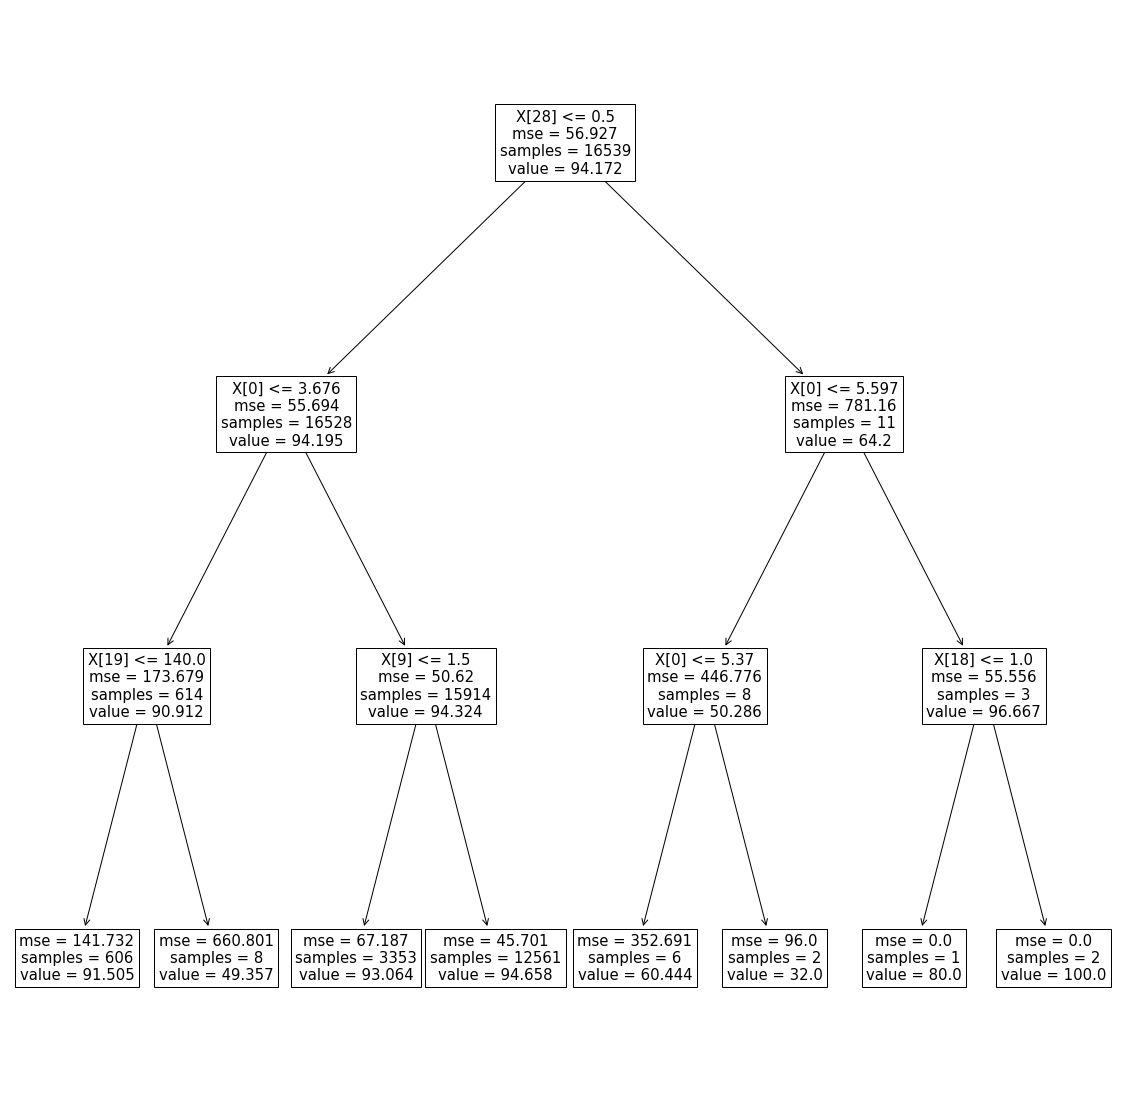

In [0]:
model=RandomForestRegressor(n_estimators=1000,max_features=np.argmin(rmspe_list)+1,bootstrap=True,max_depth=3)
model.fit(traininggo[a],traininggo['review_scores_rating'])
fig,ax = plt.subplots()
fig.set_size_inches(20,20)
plot_tree(model[0])
plt.show()

# KNN Regressor

In [0]:
np.random.seed(66)
from sklearn.preprocessing import StandardScaler
b=['logprice','Manhattan','Brooklyn','Queens','Bronx','StatenIsland','Entire','Private','Shared','minimum_nights','Hotel','Realbed',
   'Futon','Sofa','Airbed','Futon','bathrooms','bedrooms','beds','cleaning_fee','guests_included','extra_people','falseinstant',
   'trueinstant','strict14','moderate','flexible','strict30','strict60','strict','review_scores_rating']
scaler=StandardScaler()
scaler.fit(traininggo[b])
traininggo_s= scaler.transform(traininggo[b])
validationgo_s= scaler.transform(validationgo[b])
testinggo_s=scaler.transform(testinggo[b])

In [0]:
from sklearn.neighbors import KNeighborsRegressor
def best_n_neighbor(i):
  model= KNeighborsRegressor(n_neighbors=i,weights ="uniform")
  model.fit(traininggo_s[:,0:30],traininggo_s[:,30])
  prediction_KN_s= model.predict(validationgo_s[:,0:30])
  prediction_KN=prediction_KN_s*np.std(traininggo['review_scores_rating'])+np.mean(traininggo['review_scores_rating'])
  actual = validationgo['review_scores_rating'].values
  PE = (prediction_KN-actual)/actual
  RMSPE = (np.mean(PE**2))**0.5
  return RMSPE

In [0]:
# would take a while to run
rmspe_list=np.array([])
for i in range(1,31):
  rmspe_list=np.append(rmspe_list,best_n_neighbor(i))
print("The best number of neighbor to minimize the MSE is", np.argmin(rmspe_list)+1)
print("The RMSPE is", best_n_neighbor(np.argmin(rmspe_list)+1))

The best number of neighbor to minimize the MSE is 7
The RMSPE is 0.2706653763516177


# Neural Network

In [0]:
import tensorflow as tf
import tensorflow.keras as keras

In [0]:
np.random.seed(66)
def build_model(n_layers,hidden):
    model=keras.Sequential()
    model.add(  keras.layers.Flatten(input_shape=(30,)))
    for i1 in range(n_layers):
        model.add(keras.layers.Dense(hidden,activation="relu"))
    model.add(keras.layers.Dense(1))#,activation="softmax"))
    return model

In [0]:
X_train=traininggo[a].values
Y_train=traininggo['review_scores_rating'].values
X_val=validationgo[a].values
Y_val=validationgo['review_scores_rating'].values

In [0]:
layers_array =[0,1,2,3,4,5]
nodes_array = [16,32,64,128]
results=[]
for n_layers  in layers_array:
    for hidden in nodes_array:
       model0=build_model(n_layers,hidden)
       model0.compile(optimizer="adam",loss='mean_squared_error')
       result=model0.fit(X_train,Y_train,validation_data=(X_val,Y_val),
                  verbose=0)
       Y_pred=model0.predict(X_val)
       PE = (Y_pred-Y_val)/Y_val
       RMSPE = (np.mean(PE**2))**0.5
       results.append((n_layers,hidden,RMSPE))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
data=pd.DataFrame(results,columns=["n_layers","hidden","RMSPE"])
data.head()

,n_layers,hidden,RMSPE
0,0,16,0.582461
1,0,32,0.635332
2,0,64,0.601693
3,0,128,0.596162
4,1,16,0.405884


In [0]:
best=data.iloc[data["RMSPE"].idxmin()]
best_n_layers=int(best["n_layers"])
best_hidden=int(best["hidden"])
best

n_layers      5.000000
hidden      128.000000
RMSPE         0.275923
Name: 23, dtype: float64

# Linear Regression

In [0]:
cols = ['id', 'host_is_superhost',
        'host_identity_verified', 'neighbourhood',
        'neighbourhood_group_cleansed', 'latitude', 'longitude',
        'is_location_exact', 'property_type', 'room_type', 'accommodates',
        'bathrooms', 'bedrooms', 'beds', 'bed_type', 'price', 'cleaning_fee',
        'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
        'calendar_updated', 'availability_365', 
        'number_of_reviews', 'number_of_reviews_ltm', 'review_scores_rating', 'review_scores_accuracy',
        'review_scores_cleanliness', 'review_scores_checkin',
        'review_scores_communication', 'review_scores_location',
        'review_scores_value', 'instant_bookable', 'cancellation_policy',
        'reviews_per_month']
cov = AirBnb[cols]  
pd.set_option('display.max_columns', None)
print(cov.corr())

                                   id  latitude  longitude  accommodates  \
id                           1.000000 -0.012883   0.118622      0.054014   
latitude                    -0.012883  1.000000   0.073552     -0.050626   
longitude                    0.118622  0.073552   1.000000      0.013768   
accommodates                 0.054014 -0.050626   0.013768      1.000000   
bathrooms                    0.042831 -0.067765   0.010787      0.347562   
bedrooms                     0.020970 -0.075010   0.038388      0.682454   
beds                         0.043855 -0.056153   0.027450      0.761770   
price                        0.003152  0.035187  -0.138145      0.312041   
cleaning_fee                -0.046540  0.029866  -0.191307      0.491326   
guests_included              0.011026 -0.060587   0.041283      0.612046   
extra_people                -0.038533  0.008381   0.005102      0.086619   
minimum_nights              -0.067839  0.029085  -0.050935     -0.023040   
maximum_nigh

In [0]:
# forward selection
# all the other review scores are excluded from the list since they are highly correlated with our dependent variable
# all the date type variables are excluded
# property_type also excluded due to too many levels

candidate_variables = ['host_is_superhost',
                       'host_identity_verified', 
                       'neighbourhood_group_cleansed', 
                       'is_location_exact', 'room_type', 'accommodates',
                       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'price', 'cleaning_fee',
                       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
                       'calendar_updated', 'availability_365', 
                       'number_of_reviews', 'number_of_reviews_ltm',
                       'instant_bookable', 'cancellation_policy',
                       'reviews_per_month']
# exclude property_type
full = len(candidate_variables)
best_model = "review_scores_rating ~ neighbourhood_group_cleansed"
BEST_RMSPE = np.inf
actual = validation["review_scores_rating"].values
for i in np.arange(full-1,-1,-1):
  RMSPE=np.empty(i+1)
  for j in range(i+1):
    candidate_formula = best_model + " + " + candidate_variables[j]
    prediction = ols(formula = candidate_formula, data = training).fit().predict(validation)
    #prediction = np.exp(prediction)
    RMSPE[j] = (np.mean(((prediction-actual)/actual)**2))**0.5
  print(RMSPE)
  if BEST_RMSPE > np.min(RMSPE):
    Add_i = np.where(RMSPE == np.min(RMSPE))[0][0]
    best_model = best_model + " + " + candidate_variables[Add_i]
    #print(Add_i)
    print("variable added:", candidate_variables[Add_i])
   # print(best_model)
    BEST_RMSPE = np.min(RMSPE)
    candidate_variables = np.delete(candidate_variables,Add_i)    
  else:
    break
print('Best Model: ', best_model)
print('Best RMSPE: ', BEST_RMSPE)

[0.27745189 0.28075863 0.28227396 0.28223506 0.27900488 0.28227116
 0.28230948 0.28227152 0.28226944 0.28228881 0.28220882 0.282377
 0.28227319 0.28247578 0.28214704 0.28227853 0.28246614 0.27893217
 0.28176159 0.28162387 0.28091388 0.28164829 0.28187428]
variable added: host_is_superhost
[0.27582846 0.27745189 0.27738377 0.27429575 0.27740161 0.27748779
 0.2774359  0.2773921  0.27746714 0.27740574 0.27754528 0.27756919
 0.27757569 0.2773573  0.27745737 0.27618331 0.27297625 0.27819759
 0.27810978 0.27595429 0.27728821 0.27779135]
variable added: availability_365
[0.27180186 0.27297625 0.27294155 0.27049418 0.27302459 0.27308003
 0.27297746 0.27304557 0.27298526 0.27286862 0.27293618 0.27301422
 0.27312838 0.27298591 0.27297951 0.27304232 0.27350501 0.27350662
 0.27166883 0.27295893 0.2733113 ]
variable added: room_type
[0.26952763 0.27049418 0.27049671 0.27017149 0.27058772 0.27045116
 0.27035199 0.2704726  0.27050608 0.27068955 0.27063718 0.27065599
 0.27045753 0.27049608 0.27078802 

In [0]:
model = ols(best_model, validation).fit()
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     review_scores_rating   R-squared:                       0.128
Model:                              OLS   Adj. R-squared:                  0.124
Method:                   Least Squares   F-statistic:                     30.13
Date:                  Sun, 15 Dec 2019   Prob (F-statistic):           8.17e-86
Time:                          19:44:58   Log-Likelihood:                -11985.
No. Observations:                  3296   AIC:                         2.400e+04
Df Residuals:                      3279   BIC:                         2.411e+04
Df Model:                            16                                         
Covariance Type:              nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [0]:
prediction = model.predict(testing)
actual = testing["review_scores_rating"].values
test_RMSPE = (np.mean(((prediction-actual)/actual)**2))**0.5
print("Test RMSPE: ", test_RMSPE)

Test RMSPE:  0.34259433806245826


# Simple Poission Model with covariates

In [0]:
# For exploration only, no conclusive result reached.
airbnb_poission=AirBnb.copy()
airbnb_poission=airbnb_poission.assign(logpopular=np.log(airbnb_poission['reviews_per_month'].values))
airbnb_poission=airbnb_poission.assign(logprice=np.log(airbnb_poission['price'].values))
airbnb_poission=airbnb_poission.assign(Manhattan=pd.get_dummies(airbnb_poission['neighbourhood_group_cleansed'])['Manhattan'])
airbnb_poission=airbnb_poission.assign(Brooklyn=pd.get_dummies(airbnb_poission['neighbourhood_group_cleansed'])['Brooklyn'])
airbnb_poission=airbnb_poission.assign(Queens=pd.get_dummies(airbnb_poission['neighbourhood_group_cleansed'])['Queens'])
airbnb_poission=airbnb_poission.assign(Bronx=pd.get_dummies(airbnb_poission['neighbourhood_group_cleansed'])['Bronx'])
airbnb_poission=airbnb_poission.assign(StatenIsland=pd.get_dummies(airbnb_poission['neighbourhood_group_cleansed'])['Staten Island'])
airbnb_poission=airbnb_poission.assign(Entire=pd.get_dummies(airbnb_poission['room_type'])['Entire home/apt'])
airbnb_poission=airbnb_poission.assign(Private=pd.get_dummies(airbnb_poission['room_type'])['Private room'])
airbnb_poission=airbnb_poission.assign(Shared=pd.get_dummies(airbnb_poission['room_type'])['Shared room'])
airbnb_poission=airbnb_poission.assign(Superhost=pd.get_dummies(airbnb_poission['host_is_superhost'])['t'])
airbnb_poission=airbnb_poission.assign(NonSuperhost=pd.get_dummies(airbnb_poission['host_is_superhost'])['f'])
airbnb_poission=airbnb_poission.assign(Exactlocation=pd.get_dummies(airbnb_poission['is_location_exact'])['t'])
airbnb_poission=airbnb_poission.assign(NonExactlocation=pd.get_dummies(airbnb_poission['is_location_exact'])['f'])

y = airbnb_poission['number_of_reviews']
x1 = airbnb_poission['Manhattan']
x2 = airbnb_poission['Brooklyn']
x3 = airbnb_poission['Queens']
x4 = airbnb_poission['Bronx']
x5 = airbnb_poission['StatenIsland']
x6 = airbnb_poission['Entire']
x7 = airbnb_poission['Private']
x8 = airbnb_poission['Shared']
x9 = airbnb_poission['logprice']
x10 = airbnb_poission['minimum_nights']
x11 = airbnb_poission['Superhost']
x12 = airbnb_poission['NonSuperhost']
x13 = airbnb_poission['Exactlocation']
x14 = airbnb_poission['NonExactlocation']

def Neg_LL(betas):
  lmbda= np.exp(betas[0]+betas[1]*x1+betas[2]*x2+betas[3]*x3+betas[4]*x4+betas[5]*x5+\
                betas[6]*x6+betas[7]*x7+betas[8]*x8+\
                betas[9]*x9+betas[10]*x10+\
                betas[11]*x11+betas[12]*x1+\
                betas[13]*x13+betas[14]*x14)
  Ind_L= spst.poisson.pmf(y,lmbda)
  Ind_LL=np.log(Ind_L)
  return -np.sum(Ind_LL)

import warnings
warnings.simplefilter("ignore")

guess=np.random.rand(15)
model_poission=minimize(Neg_LL,guess, method="BFGS")
# print(model1.fun)
# print(model_poission.x)

betas = model_poission.x
predicted_lambda=np.exp(betas[0]+betas[1]*x1+betas[2]*x2+betas[3]*x3+betas[4]*x4+betas[5]*x5+\
                betas[6]*x6+betas[7]*x7+betas[8]*x8+\
                betas[9]*x9+betas[10]*x10+\
                betas[11]*x11+betas[12]*x1+\
                betas[13]*x13+betas[14]*x14)
#add the predicted lambda to the data frame.
airbnb_poission=airbnb_poission.assign(predicted_lambda=predicted_lambda)
airbnb_poission.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


,id,last_scraped,name,host_name,host_since,host_is_superhost,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,reviews_per_month,logpopular,logprice,Manhattan,Brooklyn,Queens,Bronx,StatenIsland,Entire,Private,Shared,Superhost,NonSuperhost,Exactlocation,NonExactlocation,predicted_lambda
0,2595,2019-12-07,Skylit Midtown Castle,Jennifer,2008-09-09,f,t,Midtown,Midtown,Manhattan,40.75362,-73.98377,f,Apartment,Entire home/apt,1,1.0,0.0,1.0,Real Bed,225.0,95.0,1,0.0,10,1125,2 weeks ago,1,2019-12-07,48,7,2009-11-21,2019-11-04,94.0,9.0,9.0,10.0,10.0,10.0,9.0,f,strict_14_with_grace_period,0.39,-0.941609,5.416100,1,0,0,0,0,1,0,0,0,1,0,1,1.605622e+04
2,5099,2019-12-06,Large Cozy 1 BR Apartment In Midtown East,Chris,2009-02-02,f,f,Manhattan,Murray Hill,Manhattan,40.74767,-73.97500,f,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,200.0,125.0,2,100.0,3,21,2 weeks ago,19,2019-12-06,78,8,2009-04-20,2019-10-13,90.0,10.0,9.0,10.0,10.0,10.0,9.0,f,moderate,0.60,-0.510826,5.298317,1,0,0,0,0,1,0,0,0,1,0,1,2.485021e+03
4,5178,2019-12-05,Large Furnished Room Near B'way,Shunichi,2009-03-03,f,f,Manhattan,Hell's Kitchen,Manhattan,40.76489,-73.98493,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,79.0,15.0,1,12.0,2,14,2 months ago,242,2019-12-05,454,47,2009-05-06,2019-11-21,84.0,9.0,7.0,9.0,9.0,10.0,8.0,f,strict_14_with_grace_period,3.52,1.258461,4.369448,1,0,0,0,0,0,1,0,0,1,1,0,1.761390e+03
6,5238,2019-12-05,Cute & Cozy Lower East Side 1 bdrm,Ben,2009-02-07,t,t,Lower East Side,Chinatown,Manhattan,40.71344,-73.99037,t,Apartment,Entire home/apt,3,1.0,1.0,2.0,Real Bed,150.0,40.0,2,10.0,1,1125,yesterday,1,2019-12-05,161,9,2009-09-01,2019-07-29,94.0,10.0,9.0,10.0,10.0,9.0,9.0,f,strict_14_with_grace_period,1.29,0.254642,5.010635,1,0,0,0,0,1,0,0,1,0,1,0,2.952918e+03
7,5441,2019-12-06,Central Manhattan/near Broadway,Kate,2009-02-16,t,t,Manhattan,Hell's Kitchen,Manhattan,40.76076,-73.98867,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,85.0,0.0,1,0.0,3,7,a week ago,10,2019-12-06,204,36,2009-03-12,2019-11-20,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,moderate,1.56,0.444686,4.442651,1,0,0,0,0,0,1,0,1,0,1,0,5.714994e+03
8,5803,2019-12-06,"Lovely Room 1, Garden, Best Area, Legal rental",Laurie,2009-03-10,t,t,Park Slope,South Slope,Brooklyn,40.66829,-73.98779,t,Townhouse,Private room,2,1.5,1.0,0.0,Real Bed,89.0,67.0,1,22.0,4,14,a week ago,0,2019-12-06,175,13,2009-04-23,2019-10-23,94.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict_14_with_grace_period,1.35,0.300105,4.488636,0,1,0,0,0,0,1,0,1,0,1,0,3.843079e+03
9,6090,2019-12-06,West Village Nest - Superhost,Alina,2009-04-01,t,t,Manhattan,West Village,Manhattan,40.73530,-74.00525,t,Apartment,Entire home/apt,1,1.0,1.0,1.0,Real Bed,120.0,150.0,1,10.0,180,365,2 months ago,271,2019-12-06,27,0,2009-08-23,2018-10-31,97.0,10.0,9.0,9.0,10.0,10.0,9.0,f,strict_14_with_grace_period,0.22,-1.514128,4.787492,1,0,0,0,0,1,0,0,1,0,1,0,6.613283e+22
11,7097,2019-12-06,Perfect for Your Parents + Garden,Jane,2009-05-17,t,t,Brooklyn,Fort Greene,Brooklyn,40.69169,-73.97185,t,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,199.0,30.0,2,30.0,1,30,a week ago,0,2019-12-06,215,40,2010-01-16,2019-12-04,97.0,10.0,10.0,10.0,10.0,10.0,9.0,t,flexible,1.79,0.582216,5.293305,0,1,0,0,0,1,0,0,1,0,1,0,1.947915e+03
12,7322,2019-12-06,"Chelsea Perfect by Doti, an AIRBNB Super Host!",Doti,2009-05-27,t,t,Manhattan,Chelsea,Manhattan,40.74192,-73.99501,t,Apartment,Private room,3,1.0,1.0,1.0,Real Bed,120.0,0.0,2,35.0,1,180,3 days ago,26,2

# Weibull Model
In this section, we want to model the timing of the first review. We observe that the earliest host_since is 2008-08-22, but the first review of the dataset is 2009-04-20. Therefore, it is reasonable to assume that the Review function is open later after some business have run for a while. We only take listings with host_since later than 2009-04-20 into account (49977 obs).

In [0]:
Listings = AirBnb.astype({"host_since":"datetime64","last_scraped": "datetime64","first_review": "datetime64"})
#listings with host_since later than 2009-04-20
AfterFirstReview=Listings[Listings["host_since"]>"2009-04-20"]
#arrival of the first review
arrive=AfterFirstReview["first_review"].copy()
#if first_review is missing, use last_scraped as censored first_review
arrive[arrive.isna()]=AfterFirstReview['last_scraped'][AfterFirstReview["first_review"].isna()]
AfterFirstReview=AfterFirstReview.assign(first_review_c=arrive)
AfterFirstReview=AfterFirstReview.assign(censor=(AfterFirstReview["first_review"].isna())*1)
AfterFirstReview=AfterFirstReview.assign(days=(AfterFirstReview["first_review_c"]-AfterFirstReview["host_since"])/np.timedelta64(1,'D'))
AfterFirstReview=AfterFirstReview[AfterFirstReview["days"]>0]

In [0]:
y=AfterFirstReview["days"]
censor=AfterFirstReview["censor"].values

def neg_LL(betas):
  c=np.exp(betas[0])
  lmbda=np.exp(betas[1])
  F_t=1-np.exp(-(y*lmbda)**c)
  F_t_m1=1-np.exp(-((y-1)*lmbda)**c)
  #censored 
  Ind_Lc=1-F_t
  #uncensored
  Ind_Lu=F_t-F_t_m1
  Ind_L=Ind_Lc*censor+Ind_Lu*(1-censor)
  return -np.sum(np.log(Ind_L))

guess=-np.array([1,8])
model1=minimize(neg_LL,guess,method="BFGS")
print(model1.fun)
print(model1.x)

251608.02564067466
[-0.23215003 -6.58204628]


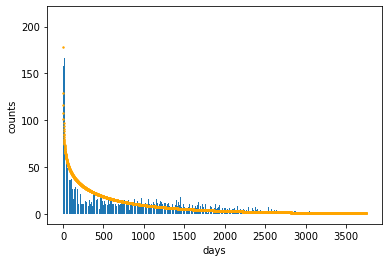

In [0]:
counts=AfterFirstReview[AfterFirstReview["censor"]==0].groupby("days").count()
y1=np.arange(1, np.max(y)+1)
betas=model1.x
c=np.exp(betas[0])
lmbda=np.exp(betas[1])
F_t=1-np.exp(-(y1*lmbda)**c)
F_t_m1=1-np.exp(-((y1-1)*lmbda)**c)
#uncensored
Ind_Lu=F_t-F_t_m1
prediction=len(y[censor==0])*Ind_Lu
plt.bar(counts.index.values, counts.iloc[:,0].values)
plt.scatter(y1,prediction,zorder=2,s=2,color="orange")
plt.xlabel("days")
plt.ylabel("counts")
plt.show()

# *Hazard*
If a listing doesn't have its first review on the ith day, the probability for this listing to receive a review on the (i+1)th day:

In [0]:
betas=model1.x
print("lambda:",np.exp(betas[1]))
print("c:",np.exp(betas[0]))
#𝜆 directly determines the scale of the hazard, implying hazard is very low
#c<1 means that our hazard decreases over time

lambda: 0.0013850122719672832
c: 0.7928271696375296


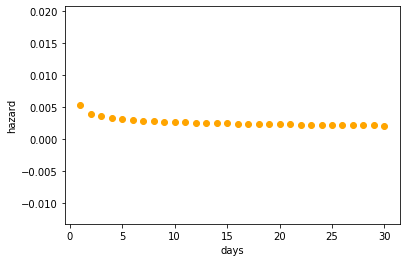

In [0]:
#the probability to receive the first review on the i days (a month)
hazard_e=(F_t-F_t_m1)/(1-F_t_m1)
plt.scatter(y1[:30],hazard_e[:30],color="orange")
plt.xlabel("days")
plt.ylabel("hazard")
plt.show()

# Two segment Weibull model
Here, we assume that there are two types of listings, one with higher 𝜆(more popular) and one segment with lower 𝜆(less popular).

In [0]:
y=AfterFirstReview["days"]
censor=AfterFirstReview["censor"].values

def neg_LL(betas):
  lmbda1=np.exp(betas[0])
  lmbda2=np.exp(betas[1])
  c=np.exp(betas[2])
  p=np.exp(betas[3])/(1+np.exp(betas[3]))
  ind_L1r=(1-np.exp(-(y*lmbda1)**c))-(1-np.exp(-((y-1)*lmbda1)**c))
  ind_L2r=(1-np.exp(-(y*lmbda2)**c))-(1-np.exp(-((y-1)*lmbda2)**c))
  ind_Lr=ind_L1r*p+ind_L2r*(1-p)
  ind_L1c=1-(1-np.exp(-(y*lmbda1)**c))
  ind_L2c=1-(1-np.exp(-(y*lmbda2)**c))
  ind_Lc=ind_L1c*p+ind_L2c*(1-p)
  ind_L=ind_Lr*(1-censor)+ind_Lc*censor
  return -np.sum(np.log(ind_L))

guess=np.array([-8,-10,-1,20])
model1=minimize(neg_LL,guess,method="BFGS")
print(model1.fun)
print(model1.x)

251608.0256926024
[ -6.58204627 -10.          -0.23215009  20.        ]


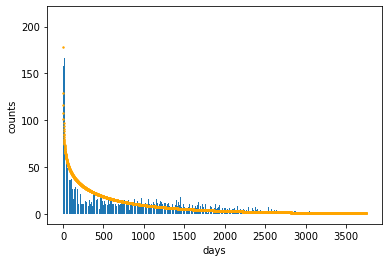

In [0]:
counts=AfterFirstReview[AfterFirstReview["censor"]==0].groupby("days").count()
plt.bar(counts.index.values, counts.iloc[:,0].values)
y1=np.arange(1,1+np.max(y))
betas=model1.x
lmbda1=np.exp(betas[0])
lmbda2=np.exp(betas[1])
c=np.exp(betas[2])
p=np.exp(betas[3])/(1+np.exp(betas[3]))
ind_L1r=(1-np.exp(-(y1*lmbda1)**c))-(1-np.exp(-((y1-1)*lmbda1)**c))
ind_L2r=(1-np.exp(-(y1*lmbda2)**c))-(1-np.exp(-((y1-1)*lmbda2)**c))
prediction=(ind_L1r*p+ind_L2r*(1-p))*len(y[censor==0])
plt.scatter(y1,prediction,zorder=2,s=2,color="orange")
plt.xlabel("days")
plt.ylabel("counts")
plt.show()

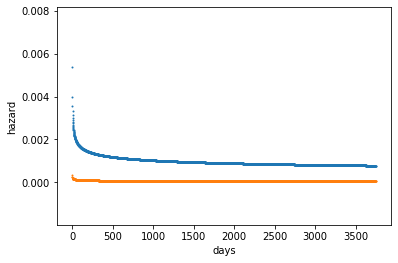

0.001385012278716385 4.5399929762484854e-05 0.792827115536586 0.9999999979388464


In [0]:
F_1=(1-np.exp(-(y1*lmbda1)**c))
F_1_m1=(1-np.exp(-((y1-1)*lmbda1)**c))
F_2=(1-np.exp(-(y1*lmbda2)**c))
F_2_m1=(1-np.exp(-((y1-1)*lmbda2)**c))
Hazard_e1=(F_1-F_1_m1)/(1-F_1_m1)
Hazard_e2=(F_2-F_2_m1)/(1-F_2_m1)
plt.scatter(y1,Hazard_e1,s=1)
plt.scatter(y1,Hazard_e2,s=1)
plt.xlabel("days")
plt.ylabel("hazard")
plt.show()

print(lmbda1,lmbda2,c,p)

In [0]:
print("Type II:",len(AfterFirstReview)*(1-0.9999999979388464))
#Type2 has 0.00010296286599253968 listings, less than one. 
#Two segments are not necessary since p=0.9999999979388464 is very close to 1. 

Type II: 6.778928013029262e-05


# Continuous observed heterogeneity

In [0]:
y=AfterFirstReview["days"]
censor=AfterFirstReview["censor"].values

def neg_LL(betas):
  alpha=np.exp(betas[0])
  gamma=np.exp(betas[1])
  c=np.exp(betas[2])
  Ft=(1-(alpha/(alpha+y**c))**gamma)
  Ft1=(1-(alpha/(alpha+(y-1)**c))**gamma)
  ind_Lr=Ft-Ft1
  ind_Lc=1-Ft
  ind_L=ind_Lr*(1-censor)+ind_Lc*censor 

  return -np.sum(np.log(ind_L))

guess= np.array([12,7,-1])
model1=minimize(neg_LL,guess,method="BFGS")
print(model1.fun)
print(model1.x)

251608.72423079048
[14.15043818  8.93108024 -0.23196298]


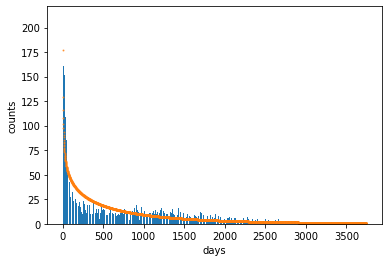

In [0]:
counts=AfterFirstReview[AfterFirstReview["censor"]==0].groupby("days").count()
betas=model1.x
y1=np.arange(1,np.max(y)+1)

alpha=np.exp(betas[0])
gamma=np.exp(betas[1])
c=np.exp(betas[2])
Ft=(1-(alpha/(alpha+y1**c))**gamma)
Ft1=(1-(alpha/(alpha+(y1-1)**c))**gamma)
ind_Lr=Ft-Ft1
prediction= ind_Lr*(len(y[censor==0]))
  
plt.bar(counts.index.values, counts.iloc[:,0].values)
plt.scatter(y1,prediction,zorder=2,s=1,alpha=0.7)
plt.xlabel("days")
plt.ylabel("counts")
plt.show()

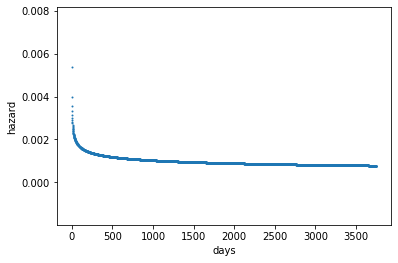

In [0]:
hazard_wg=(Ft-Ft1)/(1-Ft1)
plt.scatter(y1,hazard_wg,s=1)
plt.xlabel("days")
plt.ylabel("hazard")
plt.show()

# Weibull Model with covariates
Here, we add two variables "security_deposit" and "host_identity_verified" to the Weibull model's lmbda.

In [0]:
AfterFirstReview=AfterFirstReview.astype({"price":"str"})
AfterFirstReview[['price']]=AfterFirstReview[['price']].replace({'\$':'',',':''}, regex = True)
AfterFirstReview["price"]=[float(x) for x in AfterFirstReview["price"]]
#AfterFirstReview["security_deposit"]=[float(x) for x in AfterFirstReview["security_deposit"]]

In [0]:
AfterFirstReview_dropna=AfterFirstReview[["days","bed_type","price","censor","room_type"]].dropna()
y=AfterFirstReview_dropna["days"]
censor=AfterFirstReview_dropna["censor"].values
x1=AfterFirstReview_dropna["price"].values
x2=pd.get_dummies(AfterFirstReview_dropna["bed_type"])["Real Bed"].values
x3=pd.get_dummies(AfterFirstReview_dropna["room_type"])["Entire home/apt"].values

def neg_LL(betas):
  c=np.exp(betas[0])
  lmbda=np.exp(betas[1]+betas[2]*x1+betas[3]*x2+betas[4]*x3)
  F_t=1-np.exp(-(y*lmbda)**c)
  F_t_m1=1-np.exp(-((y-1)*lmbda)**c)
  #censored 
  Ind_Lc=1-F_t
  #uncensored
  Ind_Lu=F_t-F_t_m1
  Ind_L=Ind_Lc*censor+Ind_Lu*(1-censor)
  return -np.sum(np.log(Ind_L))

guess=np.array([-10,-10,0,0,0])
model1=minimize(neg_LL,guess,method="BFGS")
print(model1.fun)
print(model1.x)

297038.080243124
[-1.92000969e+00 -1.00001038e+01 -1.24140007e-02  1.40688164e-03
  6.51547643e-04]


In [0]:
betas=model1.x
c=np.exp(betas[0])
lmbda=np.exp(betas[1]+betas[2]*x1+betas[3]*x2+betas[4]*x3)
print(c)
print(betas[2])
print(betas[3])
print(betas[4])
print(lmbda)

0.1466055421353201
-0.01241400066973711
0.0014068816365145633
0.0006515476431399412
[3.84617469e-06 1.02485227e-05 1.33095142e-05 ... 7.06649853e-06
 1.03765409e-05 2.60022643e-05]


In [0]:
order=np.argsort(lmbda)
best=order[-1]
AfterFirstReview_dropna.iloc[best][["price","bed_type","room_type"]]

price                      0
bed_type            Real Bed
room_type    Entire home/apt
Name: 48338, dtype: object

In [0]:
top30=order[-30:]
AfterFirstReview_dropna=AfterFirstReview_dropna.assign(lmbda=lmbda)
AfterFirstReview_dropna.iloc[top30][["price","bed_type","lmbda","room_type"]]

,price,bed_type,lmbda,room_type
4334,16.0,Real Bed,0.000037,Entire home/apt
20749,15.0,Real Bed,0.000038,Private room
26740,15.0,Real Bed,0.000038,Shared room
42143,15.0,Real Bed,0.000038,Entire home/apt
21224,15.0,Real Bed,0.000038,Entire home/apt
19579,11.0,Real Bed,0.000040,Entire home/apt
30929,11.0,Real Bed,0.000040,Entire home/apt
28719,10.0,Real Bed,0.000040,Private room
29009,10.0,Real Bed,0.000040,Private room
44329,10.0,Real Bed,0.000040,Private room
